In [4]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1617255833}
{'limit': 900, 'remaining': 900, 'reset': 1617255833}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [5]:
datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

Sentiment140

In [6]:
sentiment140Value=(getQueryFromMongoDB("sentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','tweetText']]
sentiment140Value=sentiment140Value.drop_duplicates(subset=['tweetText'], keep='last')
sentiment140Value=sentiment140Value.sample(frac=1)

## Creating a Tweet Preprocessor

In [7]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer,SnowballStemmer
# lemmatizer = WordNetLemmatizer() 
lemmatizer = SnowballStemmer("english") 
# stemm=lemmatizer.lemmatize
stemm=lemmatizer.stem
punctuations=set(string.punctuation)
stopwordset=set(stopwords.words('english'))
stopwordsetNP=[re.sub(r"'",'',w) for w in stopwordset]
trans=str.maketrans('','',string.punctuation)

In [8]:
def preprocess(text):
        text = text.lower()
        text = re.sub(r"((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?",' LINKTAG ',text)    
        text = re.sub(r'[\w\.-]+@[\w\.-]+\.[\w\.\_]+',' EMAILTAG ', text)
        text = re.sub(r'(?:^|\s|$)(@[\w]+)',' USERNAMETAG ', text) #1
        text = re.sub(r"(?:^|\s|$)\#[a-zA-Z0-9_-]+", " HASHTAG ", text)
        text = re.sub(r"[']+",'', text)
        text = re.sub(r"[^ 0-9a-zA-Z]+", " ", text)#1
        text = re.sub(r"\b(.)\1{1,}", r" \1", text)
        text = re.sub(r"(.)\1{2,}", r"\1\1", text)
        text = re.sub(r"\b[0-9]+[\s]+[0-9]+\b|\b[0-9]+\b", " NUMBERTAG ", text)
        text = re.sub(r"[0-9]+", "", text)
        text = re.sub(r" \w ", " ", text)
#         text = ' '.join([stemm(w) for w in text.split()])
    #     text = ' '.join([w for w in text.split() if not w in stopwordsetNP])
        return text

## Preprocess Tweets

In [9]:
# binary=["binary"]
# hinge=["hinge"]
original3=["original3"]
cat2=["C2-bad","C2-good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 2})
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
# cat3=["C3-bad","C3-Neutral","C3-good"]
# cat5=["C5-very bad","C5-bad","C5-Neutral","C5-good","C5-very good"]
# sentiment140Value[binary]=sentiment140Value['SentimentScore'].replace({4: 1})#binary
# sentiment140Value[hinge]=sentiment140Value['SentimentScore'].replace({4: 1,0: -1})#Hinge/sq
# sentiment140Value[cat3]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 2,0: 0}))
# sentiment140Value[cat5]=to_categorical(sentiment140Value['SentimentScore'])
allscores=[]
allscores.extend(cat2)
allscores.extend(original3)
allscores.extend(['SentimentScore'])  
# allscores.extend(cat3)
# allscores.extend(binary)
# allscores.extend(hinge)
# allscores.extend(cat5)

In [10]:
sentiment140Value["processed"]=sentiment140Value["tweetText"].apply(preprocess)
sentiment140Value=sentiment140Value.drop_duplicates(subset=["processed"], keep='last')
trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value[allscores],shuffle=True, test_size=0.2,random_state=0)

In [11]:
sentiment140Value["processed"].to_csv("processedText.csv")

In [12]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [13]:
# from nltk.corpus import stopwords
# class processer():
#     def __init__(self,stemmer=None,tokenize=False,stopword=True, lower=True,links=True,retweets=True, users=True, hashtags=True, specialChars=True, nums=True, shortenBegin=True,repeats=True):
#         self.stopwordset=[]
#         if stopword: self.stopwordset=[word.translate(trans) for word in stopwords.words('english')]#Optimization
#         self.regex=r"^"
#         self.lower=lower
#         self.stemmer=stemmer
#         self.stopword=stopword
#         self.tokenize=tokenize
#         if links:        self.regex=self.regex+r"|(((((https?)?:\/\/)(www\.)?|www\.))([a-z0-9.]+)(\.[a-z]{2,4})(\.[a-z]{1,2})?([^?\s]+(\?((\w+)(=[^&\s]+)?&?)+)?)?)"
#         if retweets:     self.regex=self.regex+r"|(RT \@[a-zA-Z0-9_.]*: )"
#         if users:        self.regex=self.regex+r"|(\@[a-zA-Z0-9_.]* )"
#         if hashtags:     self.regex=self.regex+r"|(\#[a-zA-Z0-9_%]*)"
#         if specialChars: self.regex=self.regex+r"|([^\ 0-9a-zA-Z]+)"
#         if nums:         self.regex=self.regex+r"|([0-9]*)"
#         self.shortenBegin=shortenBegin
#         self.repeats=repeats
#     def stopW(self,sentence):
#         sentence=sentence.split()
#         temp=[]
#         for word in sentence:
#             if word not in self.stopwordset: #fix here
#                 if self.stemmer is not None: word=self.stemmer(word)
#                 temp.append(word)
#         if self.tokenize: return temp
#         return " ".join(temp)
#     def process(self, sentence):
#         if self.lower: sentence= sentence.lower()
#         sentence = re.sub(self.regex,"",sentence)
#         if self.shortenBegin: sentence = re.sub(r" (.)\1{1,}",r" \1",sentence)
#         if self.repeats: sentence = re.sub(r"(.)\1{2,}",r"\1\1",sentence)
#         if self.stopword: sentence= self.stopW(sentence)
#         return sentence

In [16]:
model = Pipeline([
        ('bow', CountVectorizer(max_features=300000,preprocessor=None,ngram_range=(1,2),lowercase=False)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    
model.fit(trainX.values, trainY[original3].values.flatten())
pred=model.predict(testX.values)
print(confusion_matrix(testY[original3].values,pred))
print(classification_report(testY[original3].values,pred))

[[125284  29064]
 [ 31301 120882]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81    154348
           2       0.81      0.79      0.80    152183

    accuracy                           0.80    306531
   macro avg       0.80      0.80      0.80    306531
weighted avg       0.80      0.80      0.80    306531



In [15]:
sentiment140Value["len"]=sentiment140Value["processed"].apply(lambda x:len(x.split()))

In [50]:
sentiment140Value[["len","processed"]].sort_values(by="len").to_csv("PT.csv")

In [48]:
sentiment140Value["len2"]=sentiment140Value["tweetText"].apply(lambda x:len(x.split()))
sentiment140Value["len2"].value_counts()

8     88186
7     88100
9     86468
6     84858
10    83028
11    79296
12    75569
5     74812
13    71213
14    67275
15    63098
16    59479
4     57649
17    55873
18    53286
19    51305
20    49541
21    47825
22    47136
23    45249
24    42270
25    37126
3     33541
26    29580
27    21042
28    13115
2     12115
29     7265
30     3562
31     1522
1      1358
32      589
33      209
34       69
35       20
36        6
39        4
37        2
41        2
38        1
44        1
57        1
58        1
64        1
Name: len2, dtype: int64

In [113]:
from textblob import TextBlob
SOMEVAR=sentiment140Value["tweetText"].apply(lambda x: TextBlob(x).sentiment[:])

In [114]:
sentiment,sub = zip(*SOMEVAR)

In [115]:
sentiment,sub = np.array(sentiment),np.array(sub)

In [116]:
r=pd.DataFrame(np.array([sentiment,sub ]).reshape(-1,2))

In [117]:
r=r[0].apply(np.sign).replace({1:4,0:2,-1:0})

In [112]:
r=r[0][r[0]>0.1].apply(lambda x: x=1)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-112-505f602dc45b>, line 1)

In [17]:
print(confusion_matrix(sentiment140Value["SentimentScore"],r))
print(classification_report(sentiment140Value["SentimentScore"],r))

NameError: name 'r' is not defined

In [53]:
sentiment140Value[["len","processed"]].sort_values(by="len")

len                                          processed
847215     1                                          youtube  
428906     1                                          confused 
1374043    1                                          tedward  
576192     1                                         fucksakee 
615013     1                                          raining  
...      ...                                                ...
1180226   37   USERNAMETAG  quot human quot  quot rehab quot...
1096948   39  im blue da ba dee da ba di da ba dee da ba di ...
981147    41   USERNAMETAG  do it do it do it do it do it do...
1168782   43  out in tha summer sun  having fun  nej  plugga...
1446291   52  thriving ivorys song  quot twilight quot  gt g...

[1532648 rows x 2 columns]

In [55]:
sentiment140Value.isna().sum()

_id               0
SentimentScore    0
tweetText         0
original3         0
C2-bad            0
C2-good           0
processed         0
len               0
len2              0
dtype: int64

In [40]:
# sentiment140Value["processed"][:100000].apply(lambda x: TextBlob(x).sentiment)

1206062                                     (0.0, 0.0)
979947                                    (0.125, 0.5)
1588836     (0.13636363636363635, 0.45454545454545453)
602805                                    (0.25, 0.65)
997073     (-0.13333333333333333, 0.16666666666666666)
                              ...                     
1597625                                     (0.0, 0.0)
131067     (-0.03333333333333335, 0.22222222222222224)
634999                                      (0.8, 0.7)
257027                     (0.55, 0.39999999999999997)
911436                                      (0.0, 0.0)
Name: processed, Length: 100000, dtype: object

In [274]:
# %%time
# sentiment140Value["p"].to_csv("processedText.csv")
# sentiment140Value["p"][:100] = sentiment140Value["p"][:100].apply(lambda x:spell(x))

In [ ]:
from IPython.display import clear_output
from autocorrect import Speller
spell = Speller(lang='en')
    
split=100000
increament=len(sentiment140Value)//split
rem=len(sentiment140Value)%split
time.time()
point=12000
for i in range(point,split):
    start=time.time()
    clear_output(wait=True)
    sentiment140Value["processed"][i*increament:increament*(i+1)]= sentiment140Value["processed"][i*increament:increament*(i+1)].apply(spell.autocorrect_sentence)
    print(i*"=",(split-i)*'-')
    print(i,(time.time()-start)*(split-i))
    point=i

12236 234933.97897911072


In [149]:
sentiment140Value[["_id","processed"]].to_csv("PT.csv", index=False)

Fix stopwords and stemmer being attached
FIX DAtaBase sensitive being stored as string



Capture EMAILS ends with has @ .com
Capture things that end with has @ .com

### Text Preprocessing

In [276]:
# tweetdata["processed"]=tweetdata["body"].apply(p.process)
# tweetdata=tweetdata.drop_duplicates(subset=['body'])
# dump(tweetdata,"tweetdata")
# tweetdata=load("tweetdata")

### Testing Various Input Configurations 

In [18]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### CAT

In [19]:
vec_layer = TextVectorization(
        ngrams=2,
        max_tokens=None,
        pad_to_max_tokens=True,
        output_sequence_length=50)
vec_layer.adapt(trainX.tolist())

#### CAT2

Epoch 1/100
1104/1104 [==============================] - 423s 382ms/step - loss: 0.6565 - accuracy: 0.6068 - val_loss: 0.5133 - val_accuracy: 0.7553
Epoch 2/100
1104/1104 [==============================] - 432s 391ms/step - loss: 0.4554 - accuracy: 0.7938 - val_loss: 0.4789 - val_accuracy: 0.7830
Epoch 3/100
1104/1104 [==============================] - 427s 387ms/step - loss: 0.3356 - accuracy: 0.8622 - val_loss: 0.5359 - val_accuracy: 0.7718
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 16)            49766736  
_________________________________________________________________
dense (Dense)                (None, 50, 50)            850       
_________________________________________________________________
dense

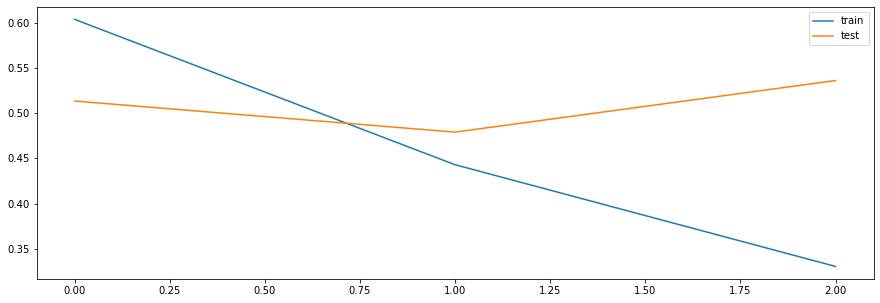

In [23]:
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)]
def LSTM_model(sequence_length = 140, embedding_dim=16,optimizer='adam'):
    M = Sequential()
    M.add(Input(shape=(1,), dtype=tf.string))
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(Dense(sequence_length, activation="relu"))
    M.add(Dense(sequence_length, activation="relu"))
    M.add(Dense(1))
    M.add(Flatten())
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M
model =LSTM_model( sequence_length = 50, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
H=model.fit(trainX, trainY[cat2],epochs=100, batch_size=1000, validation_split=0.1, callbacks=callbacks)
model.summary()
plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])

In [24]:
pred=model.predict(testX)
print(confusion_matrix(testY[original3],pd.DataFrame( pred,columns=[0,2]).idxmax(axis=1)))
print(classification_report(testY[original3],pd.DataFrame( pred,columns=[0,2]).idxmax(axis=1)))

[[123693  30156]
 [ 43222 109460]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77    153849
           2       0.78      0.72      0.75    152682

    accuracy                           0.76    306531
   macro avg       0.76      0.76      0.76    306531
weighted avg       0.76      0.76      0.76    306531



In [25]:
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=1)]
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,ngram=1,optimizer='adam',hidden=16):
    vec_layer = TextVectorization(
        ngrams=ngram,
        max_tokens=vocab_size,
        pad_to_max_tokens=True,
        output_sequence_length=sequence_length)
    vec_layer.adapt(trainX.tolist())
    print(len(vec_layer.get_vocabulary()))
    M = Sequential()
    M.add(vec_layer),
    M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
    M.add(LSTM(sequence_length, kernel_regularizer=tf.keras.regularizers.L2(l2=0.5), return_sequences =True))
    M.add(Activation(tf.keras.activations.relu))
    M.add(LSTM(sequence_length, kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), return_sequences =False))
    M.add(Activation(tf.keras.activations.relu))
    M.add(Dense(hidden, kernel_regularizer=tf.keras.regularizers.L2(l2=0.2), activation=LeakyReLU()))
    M.add(Dense(2,activation='softmax')) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M
model =LSTM_model(vocab_size = None, sequence_length = 50, embedding_dim=16,ngram=2,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),hidden=50)
H=model.fit(trainX, trainY[cat2],epochs=100, batch_size=1000, validation_split=0.1, callbacks=callbacks)


3110421
Epoch 1/100
1104/1104 [==============================] - 419s 366ms/step - loss: 7.7183 - accuracy: 0.6852 - val_loss: 0.4901 - val_accuracy: 0.7910
Epoch 2/100
1104/1104 [==============================] - 404s 366ms/step - loss: 0.4106 - accuracy: 0.8414 - val_loss: 0.4887 - val_accuracy: 0.8008
Epoch 3/100
1104/1104 [==============================] - 404s 366ms/step - loss: 0.2723 - accuracy: 0.9083 - val_loss: 0.5599 - val_accuracy: 0.7852


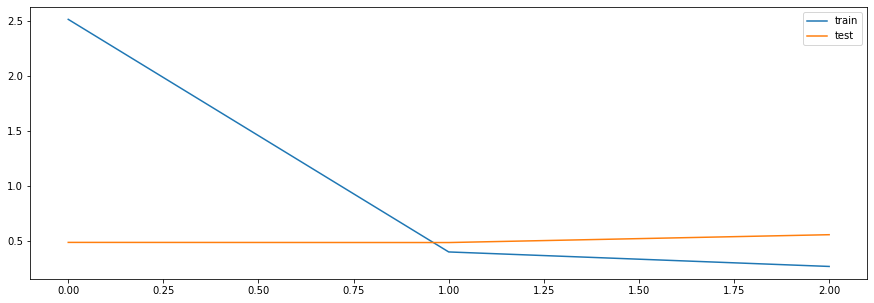

In [26]:
plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])

In [27]:
pred=model.predict(testX)
print(confusion_matrix(testY[original3],pd.DataFrame( pred,columns=[0,2]).idxmax(axis=1)))
print(classification_report(testY[original3],pd.DataFrame( pred,columns=[0,2]).idxmax(axis=1)))

[[121789  32060]
 [ 33561 119121]]
              precision    recall  f1-score   support

           0       0.78      0.79      0.79    153849
           2       0.79      0.78      0.78    152682

    accuracy                           0.79    306531
   macro avg       0.79      0.79      0.79    306531
weighted avg       0.79      0.79      0.79    306531



In [47]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
	inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
	padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
	attention = MultiHeadAttention(d_model, num_heads, name="attention")(inputs, inputs, inputs, padding_mask)
	attention = tf.keras.layers.Dropout(rate=dropout)(attention)
	attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
	outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
	outputs = tf.keras.layers.Dense(units=d_model)(outputs)
	outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
	outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
	return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
def encoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    for i in range(num_layers):
        outputs = encoder_layer(units=units,d_model=d_model,num_heads=num_heads,dropout=dropout,name="encoder_layer_{}".format(i),)([outputs, padding_mask])
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.supports_masking = True
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class ScalerMult(Layer):
    def __init__(self, d_model):
        super(ScalerMult, self).__init__()
        self.mult = tf.math.sqrt(tf.cast(d_model, tf.float32))
        self.supports_masking = True
    def call(self, inputs):
        return inputs * self.mult   
def Encoder_Model(M,embedding_dim,hidden):
    AT=MultiHeadAttention(num_heads=embedding_dim,key_dim=5)(M,M,M)
    AD1=Add()([AT,M])
    NORM1=LayerNormalization()(AD1)
    FF=Dense(hidden,'relu')(NORM1)
    FF=Dense(embedding_dim,'relu')(FF)
    AD2=Add()([FF,NORM1])
    norm=LayerNormalization()(AD2)
    return norm
#     return tf.keras.models.Model(inputs=AT,outputs=norm, name="encoder") 

In [49]:

tf.keras.backend.clear_session()
def Transformer_Encoder_Model( sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=140,encoders=1):
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)
    E=Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=False)(V)
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(len(vec_layer.get_vocabulary()),embedding_dim)(E)
    P=Masking()(P)
    out=Dense(1,'linear')(P)
#     for N in range (encoders):
#         out= out(Encoder_Model(P,embedding_dim,hidden))
#     out=Flatten()(out)
#     out=Dense(1,'linear')(out)
#     out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model=Transformer_Encoder_Model(encoders=2)
# tf.keras.utils.plot_model(Transformer_Encoder_Model)
# model.summary()
# LSTM_model()
# H=model.fit(trainX.values, trainY[cat2].values,epochs=100,batch_size=500,validation_split=0.1,callbacks=callbacks)

ResourceExhaustedError: OOM when allocating tensor with shape[3111572,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [ ]:
tf.keras.utils.plot_model(Transformer_Encoder_Model())

In [ ]:
FIX Implmentations

In [410]:
tf.keras.backend.clear_session()
def LSTM_model(vocab_size = None, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
#         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length)
#     vec_layer.adapt(trainX.tolist())
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)
    E=Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=False)(V)
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(len(vec_layer.get_vocabulary()),embedding_dim)(E)
    M=Masking()(P)
    AT=MultiHeadAttention(num_heads=embedding_dim,key_dim=5)(M,M,M)
    AD1=Add()([AT,P])
    NORM1=LayerNormalization()(AD1)
    FF=Dense(140,'relu')(NORM1)
    FF=Dense(embedding_dim,'relu')(FF)
    AD2=Add()([FF,NORM1])
    NORM2=LayerNormalization()(AD2)
    out=Dense(140,'relu')(NORM2)
    out=Dense(embedding_dim,'relu')(out)
    out=Flatten()(out)
    out=Dense(1,'linear')(out)
    out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model=LSTM_model()
tf.keras.utils.plot_model(LSTM_model())
model.summary()
# LSTM_model()
# H=model.fit(trainX.values, trainY[cat2].values,epochs=100,batch_size=500,validation_split=0.1,callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 50)           0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 16)       49758208    text_vectorization[0][0]         
__________________________________________________________________________________________________
scaler_mult (ScalerMult)        (None, 50, 16)       0           embedding[0][0]                  
______________________________________________________________________________________________

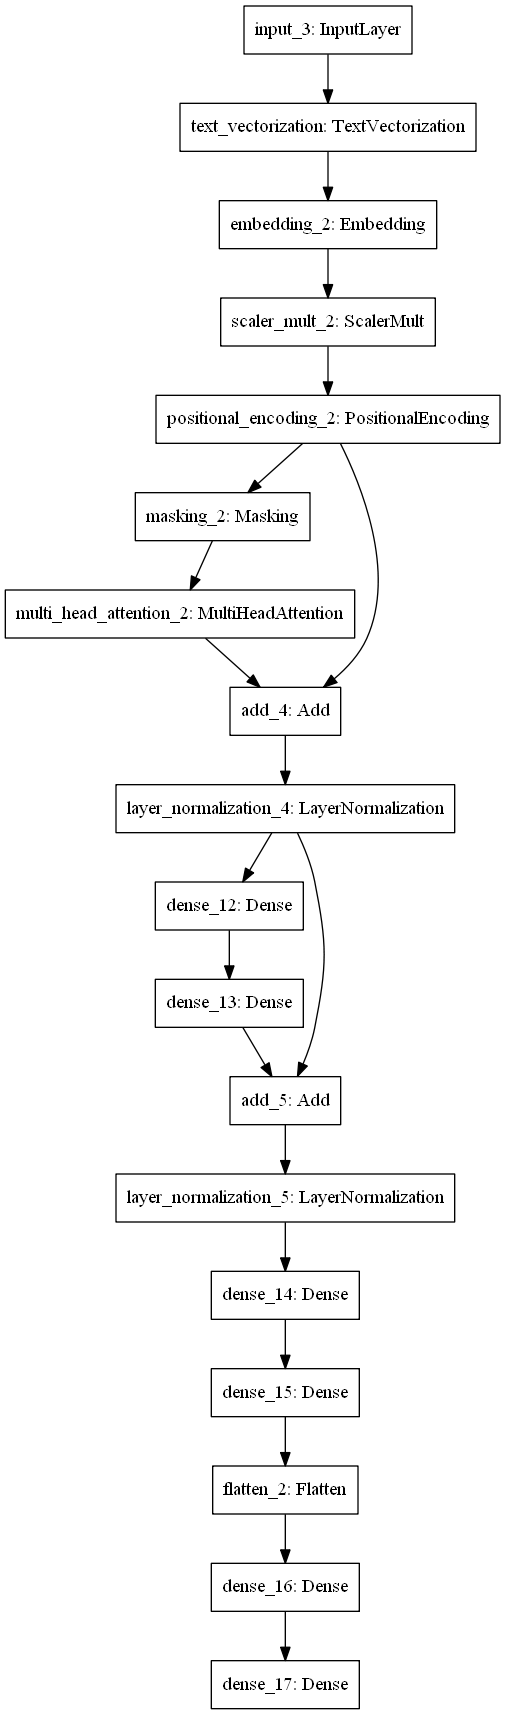

In [411]:
tf.keras.utils.plot_model(LSTM_model())

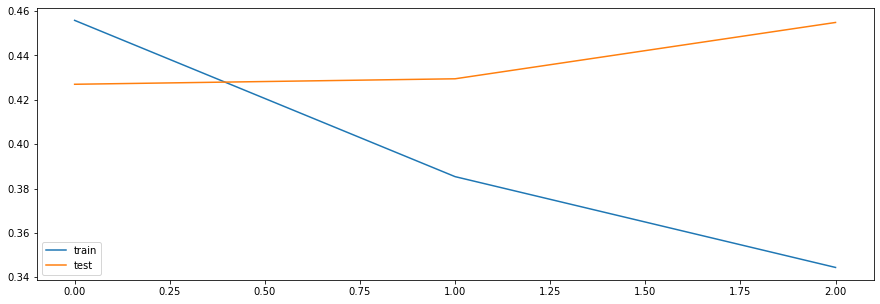

In [39]:
plotCompare(H.history['loss'],H.history['val_loss'],["train","test"])

Creating a preprocessor object

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [257]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

## Load Data

Define Which Stock to Use and Prediction Length

In [355]:
stock="MSFT"
MSFT=loadStockData(stock)
data=load(stock) #Load From Disk. Requires loadStockData to be run at least once for it to store an archived version
period=5 #lookback Period
lookAhead=5 #How many days ahead to predict 

Inspect Data for nulls

In [356]:
data=data.sort_values('Date')
print("NULLs\n")
print(data.isnull().sum())
datarange=[data.index.min().date(), data.index.max().date()]
print("Data Range: ",datarange)
data.drop(columns=["Dividends","Stock Splits"],inplace=True)

NULLs

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Data Range:  [datetime.date(1986, 3, 13), datetime.date(2021, 4, 1)]


Expand Data To Contain All Days Including The Missing Days 

In [357]:
data=data.resample('D').first()
data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
print(data["wasNa"].value_counts())

False    8836
True     3968
Name: wasNa, dtype: int64


Fill Gaps

In [358]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data=data.interpolate(method='polynomial', order=2, limit_direction='both')

In [359]:
def createTimeSeriesData(data,shifts=5,outputColumns=None,outputlengthTimeSteps=1):
    temp=data
    for i in range(1,shifts): temp=pd.merge(left=data.shift(i), left_index=True, right=temp ,right_index=True)
    temp=temp.dropna()
    if outputColumns is not None: 
        return temp[:-outputlengthTimeSteps],createTimeSeriesData(data[outputColumns],shifts=outputlengthTimeSteps)[shifts:]
    return temp

In [360]:
# Shuffle but within period (1D vs 2D)
# Try training Model From all Available stocks
dataIn,dataOut=createTimeSeriesData(data[["Close"]],outputColumns=["Close"],outputlengthTimeSteps=lookAhead,shifts=period)
dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))

In [361]:
# Shuffle but within period (1D vs 2D)
# Try training Model From all Available stocks

Split by time period

In [362]:
split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

Total Samples: 12795 			Training Samples: 10236
Total Validation Samples: 1279 		Test Samples: 1280
Input Data Shape: (5, 1) 		Output Data Shape: (5, 1)


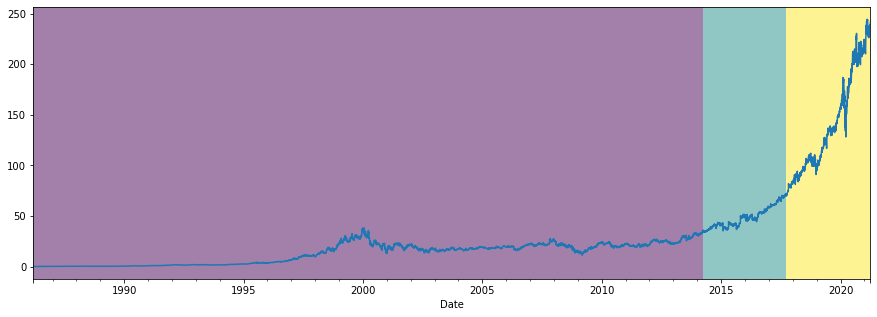

In [363]:
ax = data['Close'].plot()
f,f[len(trainx):],f[len(trainx)+len(vx):]=np.full((len(dataIn)), 1),2,3
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),f[np.newaxis],cmap='viridis', alpha=0.5)
plt.show()

In [364]:
def plotMultVariate(Din,Dout,DinSteps):
    for i in range(len(Din)):
        plt.plot(range(i,i+DinSteps),Din[i],'g')
        plt.plot(range(i,i+DinSteps),Dout[i], 'r')
    plt.show()
def plotVisual(vs,ps,period=period,t=0.5):
    for i in range(len(vs)):
        plotMultVariate(vs[:i],ps,period)
        plt.show()
        time.sleep(0.5)
        clear_output(wait=True) 

train validate test
train+validation Test
train+validate+test

moving average removes trend and seasonality
can be worse than regular time series

remove trend and seasonality using differencing avoids learning the trend but learned the differences between the periods
get a moving average of that or not and predict

series + moving avg of differenced
trailing moving average of differenced + centered moving average of past series

Take original data and shift by 1 timestep and call that baseline

split data into its seasons -> moving avg +past values m

normalization

shuffle to avoid sequence bias

error MSE RMSE MAE MAPE

using imputation

Auto Correlation 
trend
Seasonality

Transform the time series data so that it is stationary. Specifically, a lag=1 differencing to remove the increasing trend in the data.

Transform the time series into a supervised learning problem. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step

Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.

## Data Exploration

In [365]:
import kerastuner as kt

## Testing Different Models Performance

In [366]:
from tensorflow.keras.optimizers import SGD
tf.keras.backend.clear_session()
Epochs = 100
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5)]
lr_shedule=tf.keras.callbacks.LearningRateScheduler( lambda x: 1e-8*10**(x/20))

In [367]:
def compileFit(model, TrainingX=trainx, TrainingY=trainy,ValX=vx,ValY=vy,optimizer="adam",loss="mean_squared_error", patience=3,epochs=Epochs,shuffle=True,batch_size=75):
    model.compile(loss=loss,optimizer=optimizer)
    history = model.fit(TrainingX, TrainingY,shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))  
    return history

In [368]:
trainx.shape,trainy.shape
# tf.keras.regularizers.L2(l2=0.01, **kwargs)

((10236, 5, 1), (10236, 5, 1))

#### DropOUTS
### Deeper Stacking == INPHASING

In [402]:
tf.keras.backend.clear_session()
def RNN_model(hp=None):
    M = Sequential()
#     hp_units = hp.Int('units', min_value=400, max_value=512, step=32)
    hp_units=400  
    M.add(Input(shape=trainx.shape[1:]))
    M.add(LayerNormalization(axis=1))
    M.add(SimpleRNN(hp_units, return_sequences=True))
    M.add(LeakyReLU())
    M.add(SimpleRNN(hp_units))
    M.add(LeakyReLU())
    M.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001,0.000001])
#     hp_learning_rate=0.000001
    M.compile(loss="huber",optimizer=SGD(lr=hp_learning_rate, momentum=0.9),metrics=["mae"])
    return M
# model=RNN_model()
# history=model.fit(trainx, trainy,shuffle=True, batch_size=75,validation_data=(vx,vy),epochs=1000,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=3))  
tuner = kt.RandomSearch (RNN_model, objective='val_loss',
                        executions_per_trial=1,
                         overwrite=True,
                      max_trials=100,directory='my_dir',
                     project_name='RNN_model')
tuner.search(trainx, trainy, epochs=1000, validation_data=(vx,vy),batch_size=75 ,callbacks=callbacks)



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.0001            |?                 

Epoch 1/1000
 91/137 [==================>...........] - ETA: 0s - loss: 12.5008 - mae: 12.9444

KeyboardInterrupt: 

In [51]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)
best=best_hps[0]
# best.get('units'), 
best.get('learning_rate')

0.1

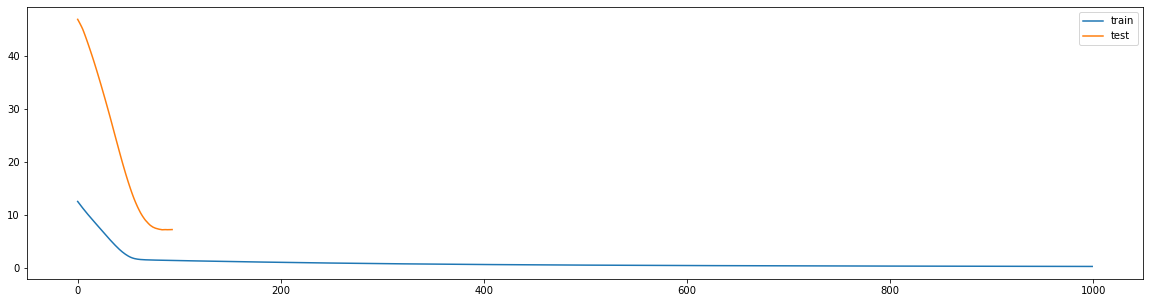

outputShape (1280, 5)


In [612]:
plotCompare(model.history['loss'],history.history['val_loss'],["train","test"])
print("outputShape",predictions.shape)
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

### Simple-RNN

In [370]:
kernel_regularizer=tf.keras.regularizers.L2(l2=0.5),

history=compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001)

SyntaxError: unexpected EOF while parsing (<ipython-input-370-fda398bea978>, line 3)

In [371]:
tf.keras.backend.clear_session()
def RNN_model(inputShape,activation='relu',hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))
#     M.add(LayerNormalization(axis=1))    
    M.add(SimpleRNN(hidden, kernel_regularizer=tf.keras.regularizers.L2(l2=0.5),activation=LeakyReLU(), return_sequences=True))
#     M.add(LeakyReLU())
    M.add(SimpleRNN(hidden,kernel_regularizer=tf.keras.regularizers.L2(l2=0.1),activation=LeakyReLU()))
#     M.add(LeakyReLU())
    M.add(Dense(1))
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber"
model=RNN_model(inputShape=trainx.shape[1:],activation='relu',hidden=400,stateful=False)
history=compileFit(model,loss='huber',optimizer=tf.keras.optimizers.Adam(lr=0.00001),shuffle=False,batch_size=100,patience=5)
model.save("RNN_model")
# model=tf.keras.models.load_model('RNN_model')

Epoch 1/100
103/103 [==============================] - 3s 14ms/step - loss: 41.4033 - val_loss: 40.5223
Epoch 2/100
103/103 [==============================] - 1s 11ms/step - loss: 39.9080 - val_loss: 39.6905
Epoch 3/100
103/103 [==============================] - 1s 12ms/step - loss: 39.0714 - val_loss: 38.8209
Epoch 4/100
103/103 [==============================] - 1s 11ms/step - loss: 38.1937 - val_loss: 37.9298
Epoch 5/100
103/103 [==============================] - 1s 12ms/step - loss: 37.2967 - val_loss: 37.0288
Epoch 6/100
103/103 [==============================] - 1s 11ms/step - loss: 36.3933 - val_loss: 36.1295
Epoch 7/100
103/103 [==============================] - 1s 11ms/step - loss: 35.4908 - val_loss: 35.2355
Epoch 8/100
103/103 [==============================] - 1s 11ms/step - loss: 34.5942 - val_loss: 34.3504
Epoch 9/100
103/103 [==============================] - 1s 11ms/step - loss: 33.7067 - val_loss: 33.4749
Epoch 10/100
103/103 [==============================] - 1s 11ms/

103/103 [==============================] - 1s 11ms/step - loss: 4.0376 - val_loss: 4.3404
Epoch 80/100
103/103 [==============================] - 1s 11ms/step - loss: 3.9243 - val_loss: 4.2301
Epoch 81/100
103/103 [==============================] - 1s 11ms/step - loss: 3.8153 - val_loss: 4.1246
Epoch 82/100
103/103 [==============================] - 1s 11ms/step - loss: 3.7106 - val_loss: 4.0228
Epoch 83/100
103/103 [==============================] - 1s 11ms/step - loss: 3.6099 - val_loss: 3.9253
Epoch 84/100
103/103 [==============================] - 1s 11ms/step - loss: 3.5132 - val_loss: 3.8314
Epoch 85/100
103/103 [==============================] - 1s 11ms/step - loss: 3.4203 - val_loss: 3.7422
Epoch 86/100
103/103 [==============================] - 1s 11ms/step - loss: 3.3310 - val_loss: 3.6553
Epoch 87/100
103/103 [==============================] - 1s 11ms/step - loss: 3.2454 - val_loss: 3.5723
Epoch 88/100
103/103 [==============================] - 1s 11ms/step - loss: 3.1632 - 

INFO:tensorflow:Assets written to: RNN_model\assets


INFO:tensorflow:Assets written to: RNN_model\assets


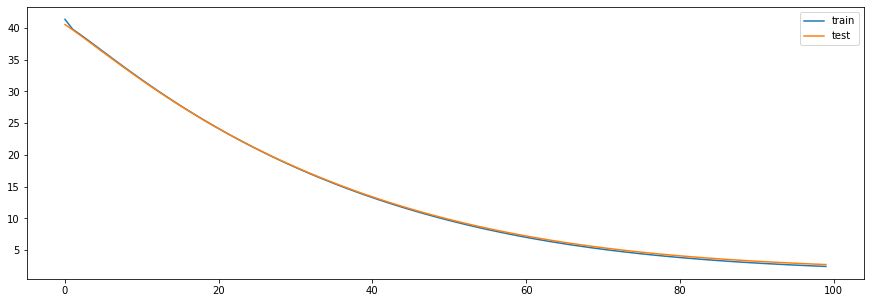

In [372]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])

outputShape (1279, 1)


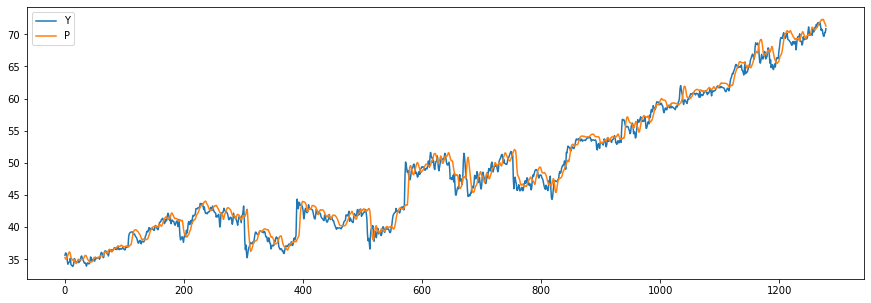

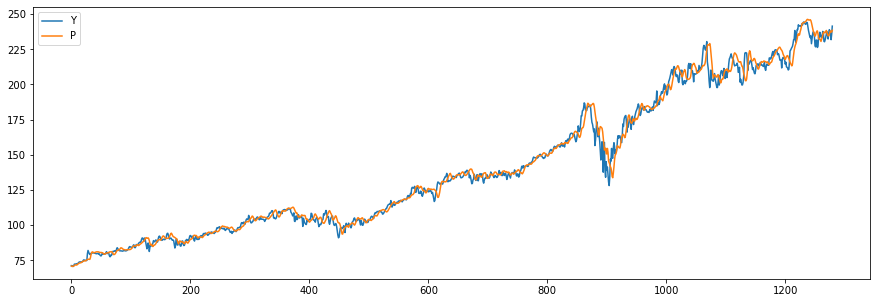

In [374]:
predictions=model.predict(vx)
print("outputShape",predictions.shape)
vEvals=model.evaluate(vx,vy,verbose=0)
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

IndexError: list index out of range

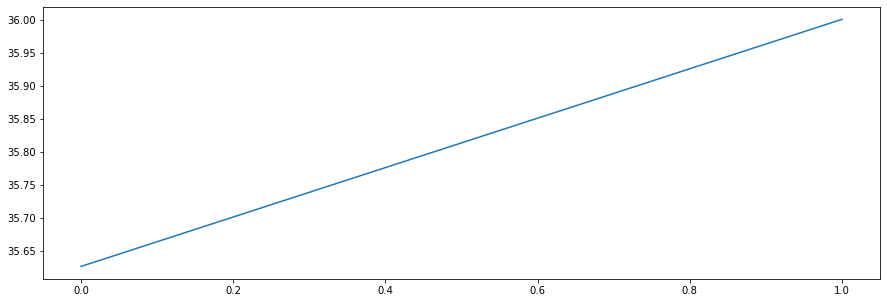

In [389]:
# predictions=model.predict(vx)
# vEvals=model.evaluate(vx,vy,verbose=0)
# plotMultVariate(vy[:100],predictions,5)

plotCompare(vy[:2,-1].flatten(),predictions)


### LSTM

In [399]:
tf.keras.backend.clear_session()
def BILSTM_model(inputShape,activation='relu',hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))
    M.add(LSTM(hidden
               ,activation=LeakyReLU()
               ,kernel_regularizer=tf.keras.regularizers.L2(l2=0.5),return_sequences=True,stateful=stateful))
    M.add(LSTM(hidden
               ,activation=LeakyReLU()
               ,kernel_regularizer=tf.keras.regularizers.L2(l2=0.2),return_sequences=False,stateful=stateful))
    M.add(Dense(5))
    return M
model=BILSTM_model(inputShape=trainx.shape[1:],activation='relu',hidden=75*5,stateful=False)
model.summary()
history=compileFit(model,optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),shuffle=False,batch_size=100,patience=5,loss='huber')
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')


Epoch 1/100
103/103 [==============================] - 5s 26ms/step - loss: 110.7702 - val_loss: 99.2982
Epoch 2/100
103/103 [==============================] - 2s 23ms/step - loss: 64.5652 - val_loss: 56.0539
Epoch 3/100
103/103 [==============================] - 3s 24ms/step - loss: 37.2875 - val_loss: 36.0304
Epoch 4/100
103/103 [==============================] - 2s 23ms/step - loss: 21.4566 - val_loss: 22.1854
Epoch 5/100
103/103 [==============================] - 2s 24ms/step - loss: 12.6559 - val_loss: 19.2178
Epoch 6/100
103/103 [==============================] - 2s 23ms/step - loss: 7.7737 - val_loss: 14.4985
Epoch 7/100
103/103 [==============================] - 2s 22ms/step - loss: 5.1573 - val_loss: 10.8176
Epoch 8/100
103/103 [==============================] - 2s 23ms/step - loss: 3.8071 - val_loss: 8.7638
Epoch 9/100
103/103 [==============================] - 2s 23ms/step - loss: 3.1237 - val_loss: 8.0356
Epoch 10/100
103/103 [==============================] - 2s 24ms/step 

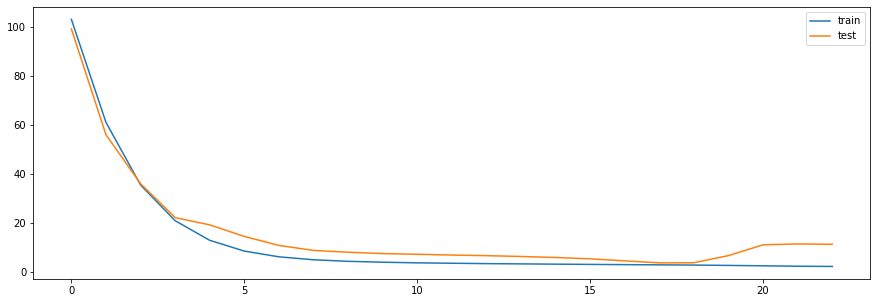

outputShape (1279, 5, 1)


In [400]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
plt.show()
predictions=model.predict(vx)
print("outputShape",predictions.shape)

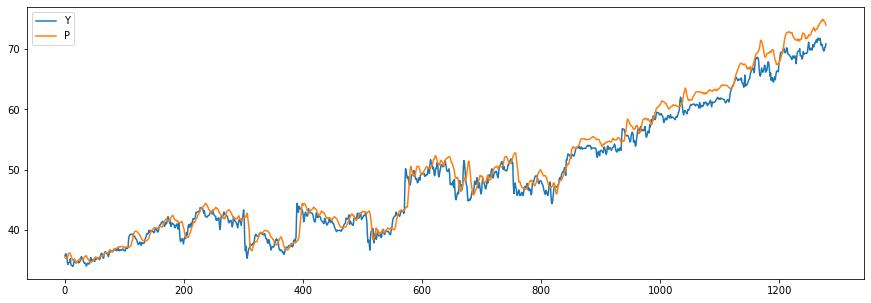

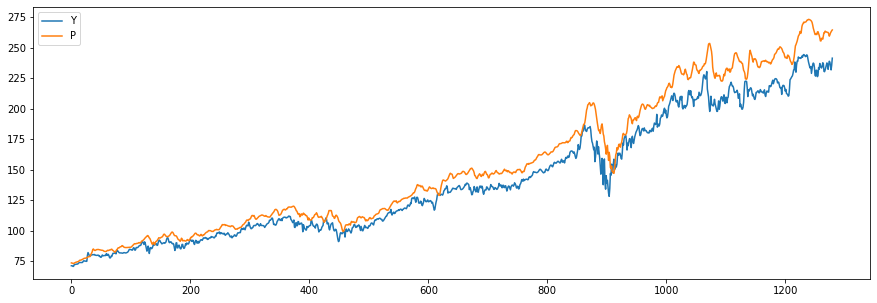

In [401]:
vEvals=model.evaluate(vx,vy,verbose=0)
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

### RESLSTM

In [352]:
def LSTM_model(inputShape, hidden=16):
    x = Input(shape=inputShape)
    E = ScalerMult(inputShape)(x)
    P = PositionalEncoding(inputShape[0], inputShape[1])(E)
    AT = MultiHeadAttention(num_heads=inputShape[0], key_dim=100)(P, P, P)
    AD1 = Add()([AT, P])
    NORM1 = LayerNormalization(axis=1)(AD1)
    FF = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.5))(NORM1)
    FF = Dense(2, 'relu')(FF)
    AD2 = Add()([FF, NORM1])
    NORM2 = LayerNormalization(axis=1)(AD2)
    out = Dense(hidden, 'relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.1))(NORM2)
    out = Dense(1, 'linear')(out)
    M = tf.keras.models.Model(inputs=x, outputs=out)
    return M


model = LSTM_model(trainx.shape[1:], 600)
model.summary()

history = compileFit(model,
                     loss='huber',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                     patience=5,
                     shuffle=True,
                     batch_size=200)

NameError: name 'ScalerMult' is not defined

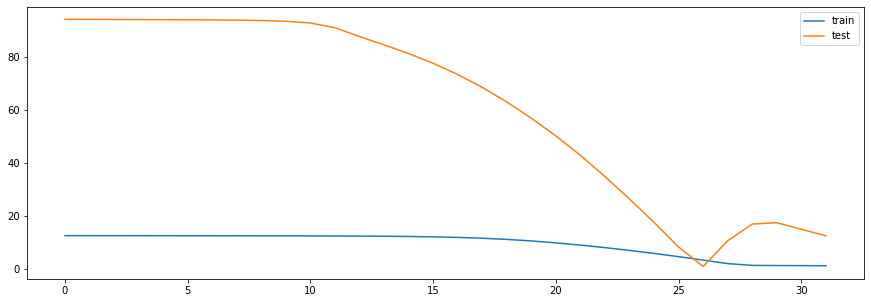

outputShape (2561, 1)


ValueError: in user code:

    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)


In [353]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
print("outputShape",predictions.shape)
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)

# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

In [354]:
def RESLSTM(shape=(1, 5, 1), stateful=True):
    x = Input(shape=shape)
    if stateful:
        x = Input(batch_shape=shape)
    y = LSTM(300, return_sequences=False, stateful=stateful)(x)
    # y = MultiHeadAttention(num_heads=2,key_dim=5)(y,y)
    D = Dense(500, kernel_initializer=tf.initializers.zeros(), activation="relu")(y)
    D = Dense(5, kernel_initializer=tf.initializers.zeros())(D)
    out = Add()([x, D])
    out = Dense(1)(out)
    return tf.keras.models.Model(inputs=x, outputs=out)


model = RESLSTM(shape=(5,1), stateful=False)
history = compileFit(model,
                     loss='huber',
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
                     patience=3,
                     shuffle=False,
                     batch_size=75)
# model.save("RESLSTM")
# model=tf.keras.models.load_model('RESLSTM')
# tf.keras.utils.plot_model(model)
model.summary()
plotCompare(history.history['loss'], history.history['val_loss'], ["train", "test"])

Epoch 1/100


ValueError: in user code:

    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\layers\recurrent.py:660 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\mech\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer lstm_3: expected shape=(None, None, 1), found shape=(None, 5, 2)


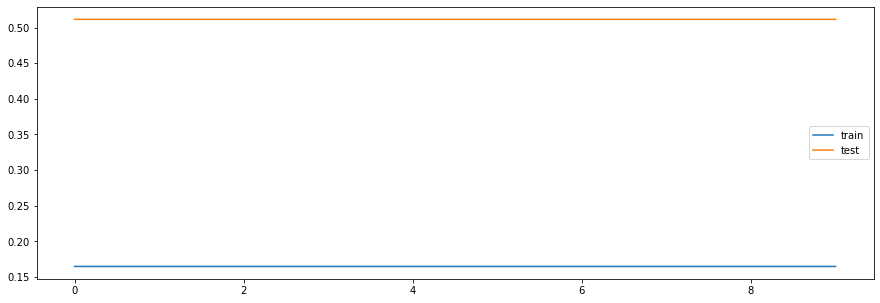

In [524]:
plotCompare(history.history['loss'][-10:], history.history['val_loss'][-10:], ["train", "test"])

outputShape (1279, 5, 1)


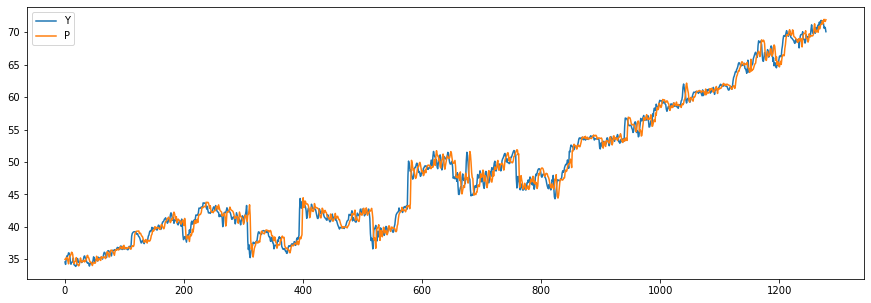

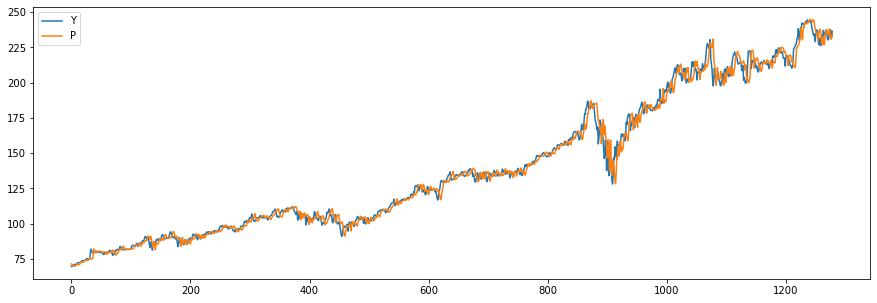

In [525]:

predictions=model.predict(vx)
print("outputShape",predictions.shape)

vEvals=model.evaluate(vx,vy,verbose=0)

# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
# print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

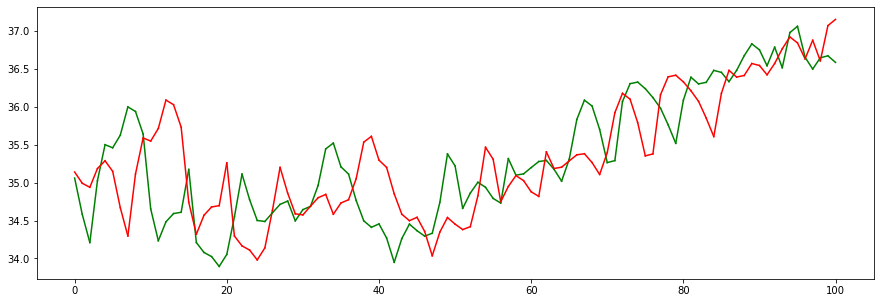

In [537]:
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
plotMultVariate(vy[:100,-2:],predictions[:,-2:],2)

### BILSTM

Epoch 1/100
10231/10231 [==============================] - 68s 6ms/step - loss: 0.0948 - mae: 0.2115 - val_loss: 13.1561 - val_mae: 13.6440
Epoch 2/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.2527 - mae: 0.3580 - val_loss: 13.0939 - val_mae: 13.5820
Epoch 3/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.2591 - mae: 0.3673 - val_loss: 13.0955 - val_mae: 13.5836
Epoch 4/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.2212 - mae: 0.3285 - val_loss: 13.0926 - val_mae: 13.5807
Epoch 5/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.1705 - mae: 0.2777 - val_loss: 13.0921 - val_mae: 13.5802
Epoch 6/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.1789 - mae: 0.3011 - val_loss: 13.0913 - val_mae: 13.5794
Epoch 7/100
10231/10231 [==============================] - 63s 6ms/step - loss: 0.1529 - mae: 0.2675 - val_loss: 13.0915 - val_mae: 13.5796
Epoch 8/100
10231/10

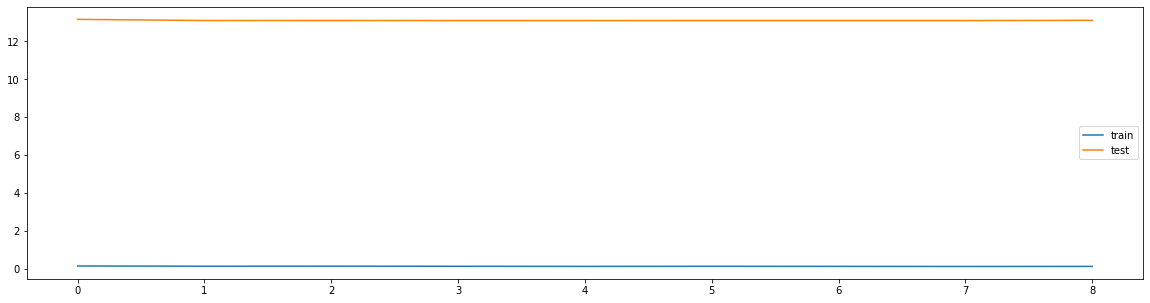

In [ ]:
tf.keras.backend.clear_session()
def BILSTM_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))
    M.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
    M.add(Bidirectional(LSTM(lstm,return_sequences=True,stateful=stateful)))
    M.add(LeakyReLU())
    M.add(Bidirectional(LSTM(lstm,return_sequences=False,stateful=stateful)))
    M.add(LeakyReLU())
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1))
    M.add(Lambda(lambda x: x * 100.0))
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber"
model=BILSTM_model(inputShape=(1,5),activation='relu',hidden=16,stateful=True)
history=compileFit(model,loss='huber',optimizer=SGD(lr=0.0001, momentum=0.8),shuffle=False,batch_size=1,patience=3)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')

In [ ]:
predictions=model.predict(vx,batch_size=1)
plotCompare(vy.values,predictions[:,-1],["Y","P"])

### LSTM

Epoch 1/100
10231/10231 [==============================] - 54s 5ms/step - loss: 0.1331 - mae: 0.2753 - val_loss: 13.5974 - val_mae: 14.0873
Epoch 2/100
10231/10231 [==============================] - 51s 5ms/step - loss: 0.8519 - mae: 1.0463 - val_loss: 13.6143 - val_mae: 14.1044
Epoch 3/100
10231/10231 [==============================] - 51s 5ms/step - loss: 0.3685 - mae: 0.5713 - val_loss: 12.0193 - val_mae: 12.5084
Epoch 4/100
10231/10231 [==============================] - 51s 5ms/step - loss: 0.8079 - mae: 1.0815 - val_loss: 13.4531 - val_mae: 13.9415
Epoch 5/100
10231/10231 [==============================] - 49s 5ms/step - loss: 0.6812 - mae: 0.9530 - val_loss: 13.7824 - val_mae: 14.2744
Epoch 6/100
10231/10231 [==============================] - 50s 5ms/step - loss: 0.6882 - mae: 0.9520 - val_loss: 13.7136 - val_mae: 14.2049


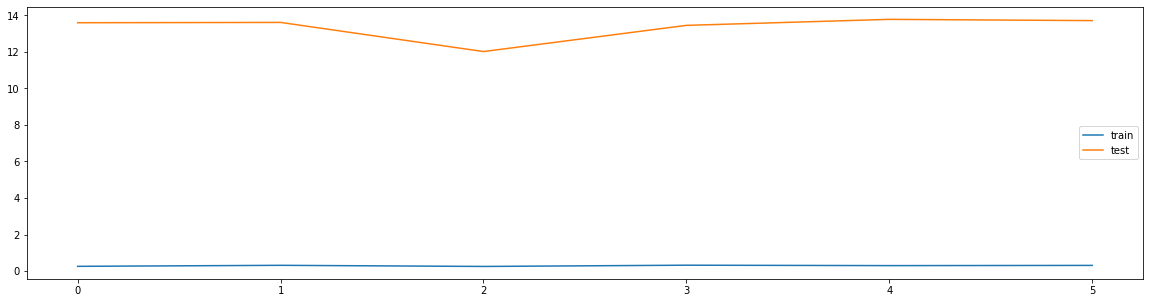

In [195]:
tf.keras.backend.clear_session()
def LSTM_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else: M.add(Input(shape=inputShape))
    M.add(Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
    M.add(LSTM(lstm,return_sequences=True,stateful=stateful))
    M.add(LeakyReLU())
    M.add(Dropout(0.2))
    M.add(LSTM(lstm,return_sequences=False,stateful=stateful))
    M.add(LeakyReLU())
    M.add(Dropout(0.2))
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1,activation="relu"))
    return M
model=LSTM_model(inputShape=(5),activation='relu',lstm=100,hidden=16,stateful=False)
history=compileFit(model,loss='huber',optimizer=SGD(lr=0.001, momentum=0.8),shuffle=False,batch_size=1,patience=3)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
# model.save("LSTM_model")
# model=tf.keras.models.load_model('LSTM_model')

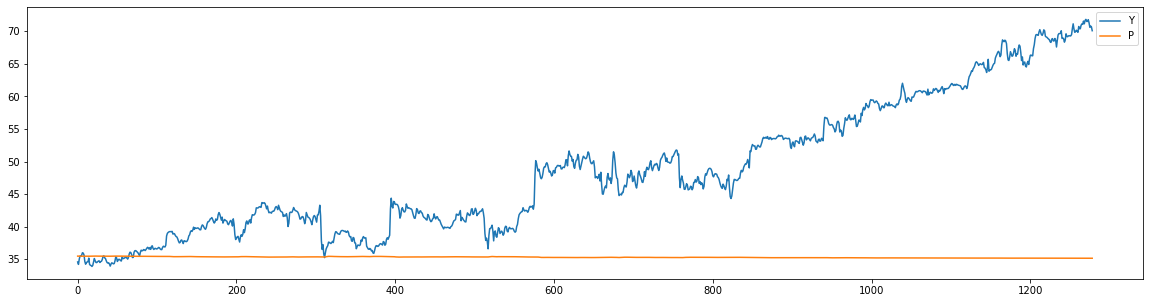

In [191]:
predictions=model.predict(vx,batch_size=75)
plotCompare(vy.values[:,-1],predictions[:,-1],["Y","P"])

In [194]:
model.predict(vx[:-10])

array([[35.4782  ],
       [35.47349 ],
       [35.469997],
       ...,
       [35.15849 ],
       [35.158146],
       [35.158047]], dtype=float32)

### ConvLSTM

In [ ]:
tf.keras.backend.clear_session()
def CovLSTM_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    if stateful: M.add(Input(batch_input_shape=inputShape))
    else:M.add(Input(shape=inputShape))
    M.add(Conv1D(filters=32, kernel_size=2,strides=1,
           padding="causal",activation="relu",
           input_shape=[None, 1]))
    M.add(LSTM(lstm,return_sequences=True,stateful=stateful))
    M.add(LeakyReLU())
    M.add(Dense(hidden, activation=activation))
    M.add(Dense(1))
#     M.add(Lambda(lambda x: x * 100.0))
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber"
#    
model=BILSTM_model(inputShape=(1,5),activation='relu',hidden=16,stateful=True)
history=compileFit(model,loss='huber',optimizer=SGD(lr=0.0001, momentum=0.8),shuffle=False,batch_size=1,patience=3)
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
model.save("CovLSTM_model")
# model=tf.keras.models.load_model('CovLSTM_model')

In [ ]:
predictions=model.predict(vx,batch_size=1)
plotCompare(vy.values,predictions[:,-1],["Y","P"])

### DNN

In [408]:
tf.keras.backend.clear_session()
def DNN_model(inputShape,activation='relu',lstm=16,hidden=16, stateful=False):
    M = Sequential()
    M.add(Input(shape=inputShape))
    M.add(Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.5), activation="relu"))
    M.add(Dense(512, kernel_regularizer=tf.keras.regularizers.L2(l2=0.1), activation="relu"))
    M.add(Dense(1, activation="relu"))
#     
    return M
# losses 'mean_squared_logarithmic_error','mean_squared_error',
#        'mean_absolute_error' "huber" 
model=DNN_model(inputShape=trainx.shape[1:],activation='relu',hidden=20)
history=compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),epochs=10000,batch_size=75,patience=10)
# model.save("DNN_model")
# model=tf.keras.models.load_model('DNN_model')
model.summary()

Epoch 1/10000
137/137 [==============================] - 1s 4ms/step - loss: 324.9332 - val_loss: 2519.8516
Epoch 2/10000
137/137 [==============================] - 0s 3ms/step - loss: 318.7436 - val_loss: 2517.2649
Epoch 3/10000
137/137 [==============================] - 0s 3ms/step - loss: 317.1026 - val_loss: 2514.8052
Epoch 4/10000
137/137 [==============================] - 0s 3ms/step - loss: 310.9986 - val_loss: 2512.4636
Epoch 5/10000
137/137 [==============================] - 0s 3ms/step - loss: 312.0684 - val_loss: 2510.2329
Epoch 6/10000
137/137 [==============================] - 0s 3ms/step - loss: 311.8953 - val_loss: 2508.1074
Epoch 7/10000
137/137 [==============================] - 0s 3ms/step - loss: 313.1674 - val_loss: 2506.0801
Epoch 8/10000
137/137 [==============================] - 0s 3ms/step - loss: 302.1591 - val_loss: 2504.1467
Epoch 9/10000
137/137 [==============================] - 0s 3ms/step - loss: 301.5847 - val_loss: 2502.3018
Epoch 10/10000
137/137 [====

KeyboardInterrupt: 

In [ ]:
plotCompare(history.history['loss'],history.history['val_loss'],["train","test"])
print("outputShape",predictions.shape)
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
%store vEvals >>a.txt
print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vy[:,-1],predictions[:,-1],["Y","P"])
predictions=model.predict(tx)
tEvals=model.evaluate(tx,ty,verbose=0)
print("Test Loss:",tEvals[0],"\tTest MAE:",tEvals[1])
plotCompare(ty[:,-1],predictions[:,-1],["Y","P"])

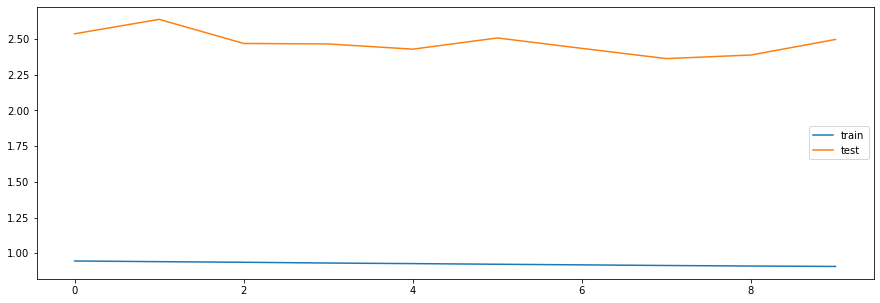

In [260]:
plotCompare(history.history['loss'][-10:],history.history['val_loss'][-10:],["train","test"])

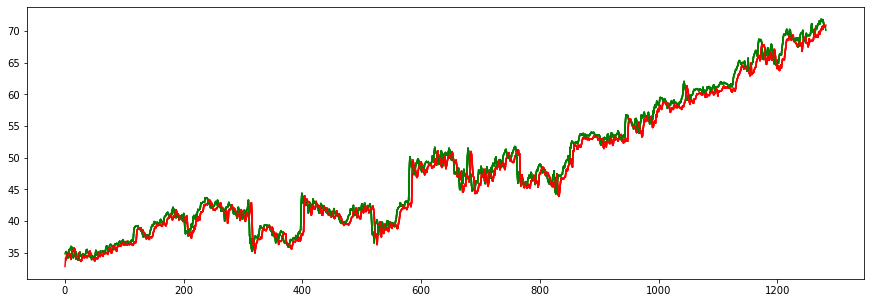

In [261]:
predictions=model.predict(vx)
vEvals=model.evaluate(vx,vy,verbose=0)
plotMultVariate(vy,predictions,5)

In [351]:
plotVisual(vx,predictions,5)
# iiii=9
# plt.plot(range(iiii,iiii+5),vy[iiii],range(iiii,iiii+5),predictions[iiii])

KeyError: 0

### Positional Encoding

In [1606]:
# s=50
# plt.plot(vy[:s])
# for v in range(0,len(predictions[:s])-period):
#     plt.plot(vy.index[v+1:v+period+1],predictions[v])
#     print(v,v+period,v)

In [1582]:
def predict_N_Days(model,data,days=5):
    shift=len(data)
    data=data.flatten()
    for i in range(days):
        prediction=model.predict(data[i:].reshape(1,shift,-1))[:,-1]
        data=np.append(data,prediction)
    return data[shift:]
def predict_N_Days_N_Samples(model,data,shifts=5):
    shift=len(data)*[None]
    for i in range(len(shift)):
        shift[i]=predict_N_Days(model,data[i],shifts)
    return shift

days=2
samples=10
# ps=predict_N_Days_N_Samples(model,vx[:samples],days)
p=predict_N_Days(model,vx[0],days=5)
plt.plot(vy["Close"][:samples+days])
# for v in range(samples): plt.plot(vy.index[v:v+days],ps[v][-1])

KeyError: 0

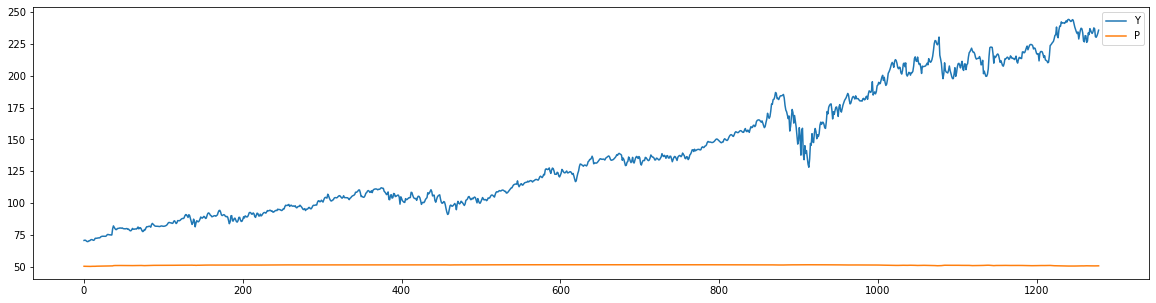

In [1537]:
predictions=model.predict(tx)
plotCompare(ty.values,predictions[:,-1],["Y","P"])

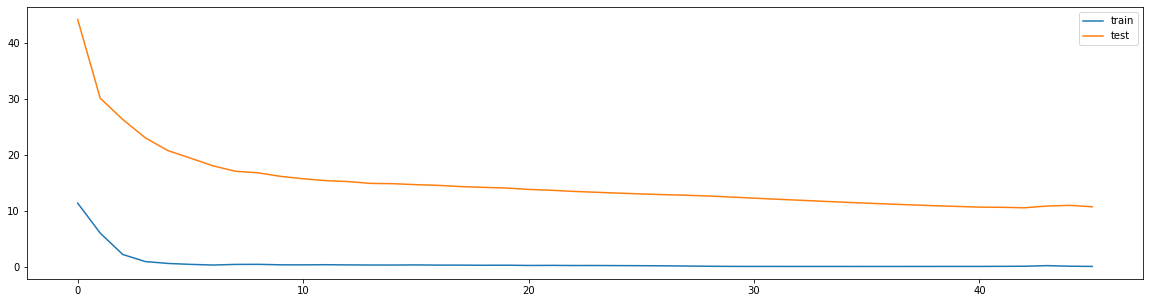

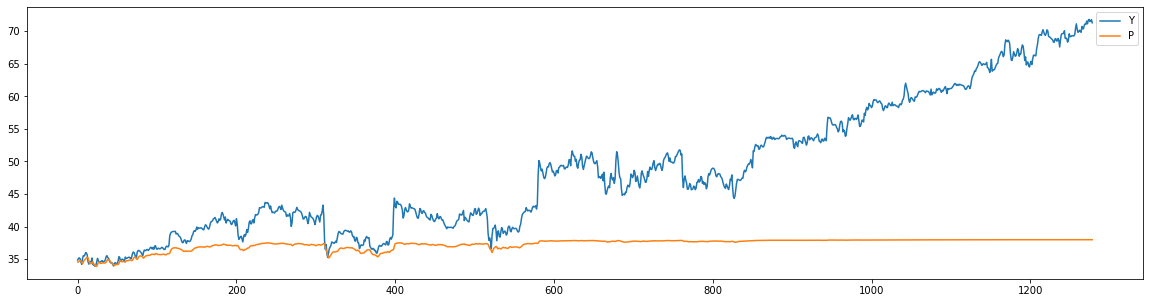

# Applying Sentiment to our models 

In [126]:
# insterDFToDB("processedSentiment140",sentiment140Value[["_id","SentimentScore","processed"]])

In [47]:
tweetdata

body
post_date                                                    
2015-01-01  lx21 made $10,008  on $AAPL -Check it out! htt...
2015-01-01  Insanity of today weirdo massive selling. $aap...
2015-01-01  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...
2015-01-01  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...
2015-01-01  Swing Trading: Up To 8.91% Return In 14 Days h...
...                                                       ...
2019-12-31  That $SPY $SPX puuump in the last hour was the...
2019-12-31  In 2020 I may start Tweeting out positive news...
2019-12-31  Patiently Waiting for the no twitter sitter tw...
2019-12-31  I don't discriminate. I own both $aapl and $ms...
2019-12-31  $AAPL #patent 10,522,475 Vertical interconnect...

[3717964 rows x 1 columns]

In [59]:
pss=pd.DataFrame(tweetdata["body"][tweetdata["body"].str.contains("tsla|tesla", case=False, flags=0, na=None, regex=True)].apply(preprocess))
pss=pss.drop_duplicates(subset=['body'], keep='last')
pss=pss.sample(frac=1)

In [67]:
pss["2015"].

KeyError: '2015'

In [64]:
pss.resample('D').first()
# data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
# print(data["wasNa"].value_counts())

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [73]:
model = Pipeline([
        ('bow', CountVectorizer(max_features=300000,preprocessor=preprocess,ngram_range=(1,2),lowercase=False)),  # strings to token integer counts
        ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
        ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
    ])
    
model.fit(trainX.values, trainY[original3].values.flatten())
pred=model.predict(testX.values)
print(confusion_matrix(testY[original3].values,pred))
print(classification_report(testY[original3].values,pred))

[[125263  29085]
 [ 31272 120911]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.81    154348
           2       0.81      0.79      0.80    152183

    accuracy                           0.80    306531
   macro avg       0.80      0.80      0.80    306531
weighted avg       0.80      0.80      0.80    306531



In [75]:
pss

body  sentiment
post_date                                                               
2016-04-15   crmd reviews updated friday  april  NUMBERTAG...          2
2019-01-11  service king in texas  listed online as tesla ...          2
2018-09-13  indeed  have warned investors to secure their ...          2
2017-07-06   HASHTAG  shares down more than  NUMBERTAG   t...          2
2019-08-12    NUMBERTAG  for pharma  they label things as ...          2
...                                                       ...        ...
2018-03-30   t securities  lc purchases  NUMBERTAG  shares...          2
2017-12-22   HASHTAG  subsidiary esteq  investment and key...          2
2018-11-19  tfw you wake up with bad flu and someone tells...         -1
2018-04-04   HASHTAG  model  NUMBERTAG  wins the popular m...          2
2019-08-25   tsla nearly hit the   NUMBERTAG  level again ...         -1

[969738 rows x 2 columns]

In [62]:
pss["sentiment"]=model.predict(pss["body"].values)

In [84]:
pss["sentiment"]=pss["sentiment"].replace({0:-1,2:1})

In [85]:
# pss.set_index(pd.to_datetime(pss.index, unit='d',utc=True).dt.date)

In [86]:
# TSLA=load("TSLA")
# TSLA=loadStockData(stock)
print(tweetdata.index.min(), tweetdata.index.max())
print(TSLA.index.min(), TSLA.index.max())
mini,maxi=None,None
if tweetdata.index.min()>TSLA.index.min(): mini=tweetdata.index.min()
else: mini= TSLA.index.min()
if tweetdata.index.max()>TSLA.index.max(): mini=TSLA.index.max()
else: maxi= tweetdata.index.max()
print(mini,"-",maxi)

2015-01-01 2019-12-31
2010-06-29 00:00:00 2021-03-31 00:00:00
2015-01-01 - 2019-12-31


In [4]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [87]:
pss

body  sentiment
post_date                                                               
2016-04-15   crmd reviews updated friday  april  NUMBERTAG...          1
2019-01-11  service king in texas  listed online as tesla ...          1
2018-09-13  indeed  have warned investors to secure their ...          1
2017-07-06   HASHTAG  shares down more than  NUMBERTAG   t...          1
2019-08-12    NUMBERTAG  for pharma  they label things as ...          1
...                                                       ...        ...
2018-03-30   t securities  lc purchases  NUMBERTAG  shares...          1
2017-12-22   HASHTAG  subsidiary esteq  investment and key...          1
2018-11-19  tfw you wake up with bad flu and someone tells...         -1
2018-04-04   HASHTAG  model  NUMBERTAG  wins the popular m...          1
2019-08-25   tsla nearly hit the   NUMBERTAG  level again ...         -1

[969738 rows x 2 columns]

In [72]:
# tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla|tesla", case=False, na=None, regex=True)]
# tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
# tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
# tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
# tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

<ipython-input-72-fedfca0b24ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
<ipython-input-72-fedfca0b24ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)


In [90]:
pss["good"],pss["bad"]=pss["sentiment"].apply(lambda x: x==1 and 1 or 0),pss["sentiment"].apply(lambda x: x==-1 and 1 or 0)
pss=pss.groupby(pss.index).sum()
pss=pss.set_index(pd.to_datetime(pss.index))
pss

sentiment  good  bad
post_date                       
2015-01-01         30    47   17
2015-01-02         38    99   61
2015-01-03         24    48   24
2015-01-04         24    56   32
2015-01-05         89   153   64
...               ...   ...  ...
2019-12-27        378   821  443
2019-12-28        180   388  208
2019-12-29        149   372  223
2019-12-30        268   821  553
2019-12-31        366   709  343

[1826 rows x 3 columns]

In [129]:
pss["diff"]=pss["good"]-pss["bad"]
pss["str"]=pss["diff"]/(pss["good"]+pss["bad"])
pss["sign"]=np.sign(pss["diff"])
pss["change"]=(pss["diff"]-pss["diff"].shift(1)).fillna(0)
pss["changeS"]=np.sign(pss["change"])
pss=pss.resample('D').first()
pss=pss.ffill()

In [9]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [10]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [130]:
pss.index.max(),pss.index.min(),TSLA.index.max(),TSLA.index.min()

(Timestamp('2019-12-31 00:00:00', freq='D'),
 Timestamp('2015-01-01 00:00:00', freq='D'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2010-06-29 00:00:00'))

In [131]:
mini=pss.index.min()
maxi=pss.index.max()

<AxesSubplot:>

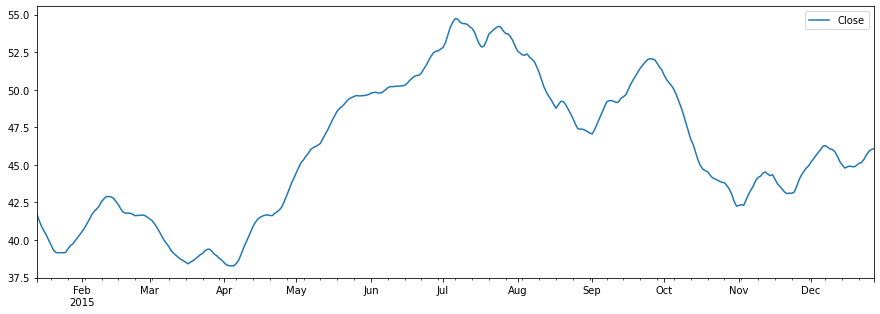

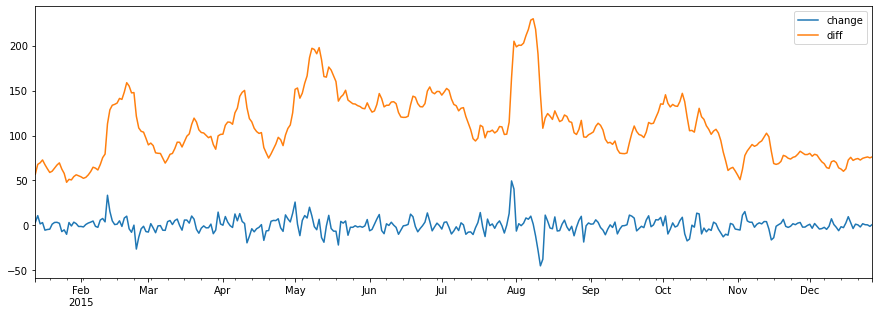

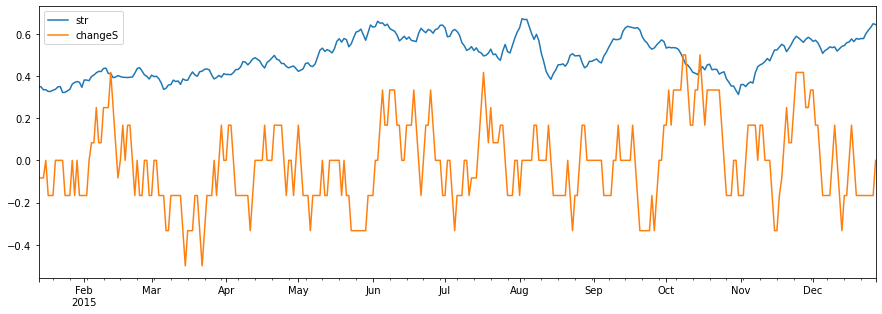

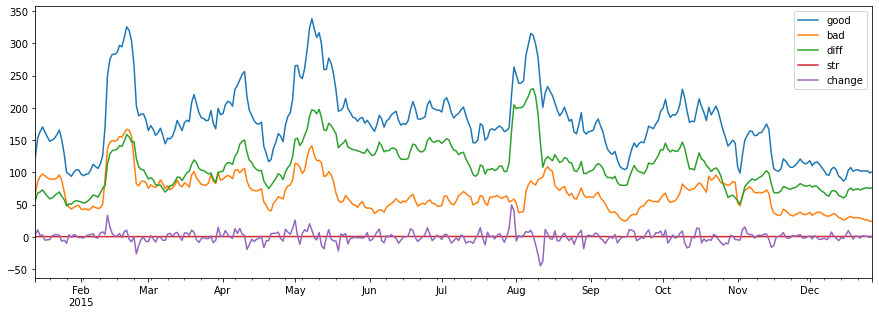

In [132]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data, left_index=True, right=pss, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

In [134]:
commonr

Open       High        Low      Close        Volume  \
2015-01-12  42.608673  42.850898  41.427752  42.064669  2.488370e+07   
2015-01-13  42.278797  42.562791  41.132752  41.774859  2.537677e+07   
2015-01-14  41.661464  42.095291  40.661752  41.331193  2.820489e+07   
2015-01-15  41.211381  41.669382  40.320188  40.933334  2.823104e+07   
2015-01-16  40.741399  41.259912  39.986114  40.625974  2.774917e+07   
...               ...        ...        ...        ...           ...   
2019-12-27  81.178957  82.770226  80.342156  81.995421  6.374007e+07   
2019-12-28  82.478519  83.637071  81.345692  82.727754  6.056778e+07   
2019-12-29  83.529353  84.448002  82.028269  83.365483  6.227617e+07   
2019-12-30  84.332020  85.011003  82.506269  83.724650  6.163676e+07   
2019-12-31  84.460020  85.251669  82.599269  83.962816  5.837784e+07   

               wasNa   sentiment        good         bad        diff  \
2015-01-12  0.416667   53.500000  103.250000   49.750000   53.500000   
2015-01-13  0.333333   57.000000  124.333333   67.333333   57.000000   
2015-01-14  0.333333   67.916667  153.583333   85.666667   67.916667   
2015-01-15  0.250000   69.666667  163.250000   93.583333   69.666667   
2015-01-16  0.166667   72.833333  170.500000   97.666667   72.833333   
...              ...         ...         ...         ...         ...   
2019-12-27  0.250000  365.500000  773.000000  407.500000  365.500000   
2019-12-28  0.333333  348.916667  722.583333  373.666667  348.916667   
2019-12-29  0.416667  338.000000  697.916667  359.916667  338.000000   
2019-12-30  0.416667  312.333333  660.166667  347.833333  312.333333   
2019-12-31  0.416667  327.583333  685.416667  357.833333  327.583333   

                 str  sign     change   changeS  
2015-01-12  0.377193   1.0   6.083333  0.000000  
2015-01-13  0.349494   1.0   3.500000 -0.083333  
2015-01-14  0.348968   1.0  10.916667 -0.083333  
2015-01-15  0.334441   1.0   1.750000 -0.083333  
2015-01-16  0.334780   1.0   3.166667  0.000000  
...              ...   ...        ...       ...  
2019-12-27  0.318440   1.0  21.916667  0.000000  
2019-12-28  0.323954   1.0 -16.583333 -0.166667  
2019-12-29  0.322726   1.0 -10.916667 -0.166667  
2019-12-30  0.314640   1.0 -25.666667 -0.166667  
2019-12-31  0.319387   1.0  15.250000  0.000000  

[1815 rows x 14 columns]

# Results

In [252]:
# dataIn,dataOut=createTimeSeriesData(commonr[["Close","sentiment"]],outputColumns=["Close"],outputlengthTimeSteps=lookAhead,shifts=period)
# dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
# dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))
# split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

Total Samples: 1810 			Training Samples: 1448
Total Validation Samples: 181 		Test Samples: 181
Input Data Shape: (2,) 		Output Data Shape: (5,)


In [272]:
trainx,vtx,trainy,vty=train_test_split(data[:-1][["Close"]].values.reshape(-1,1,1),data[:-1][["Close"]].values.reshape(-1,1,1),test_size=0.2,shuffle=False)

In [348]:
tf.keras.backend.clear_session()
def LSTM_model(inputShape,activation='relu',lstm=16,hidden=16):
    M = Sequential()
    M.add(LSTM(lstm,"relu",input_shape=(1,1),return_sequences=True))
    M.add(LSTM(lstm,"relu",return_sequences=True))
    M.add(LSTM(1,"relu",return_sequences=False))
    M.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),loss="huber")
    return M
model=LSTM_model(inputShape=trainx.shape[1:],activation='relu',lstm=100,hidden=16)
history=model.fit(trainx, trainy,epochs=100, batch_size=1000, validation_data=(vtx,vty), callbacks=callbacks)

Epoch 1/100
11/11 [==============================] - 3s 50ms/step - loss: 12.4689 - val_loss: 94.1976
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 12.5029 - val_loss: 94.1757
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 12.4968 - val_loss: 94.1477
Epoch 4/100
11/11 [==============================] - 0s 12ms/step - loss: 12.5592 - val_loss: 94.1178
Epoch 5/100
11/11 [==============================] - 0s 13ms/step - loss: 12.5600 - val_loss: 94.0844
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 12.4997 - val_loss: 94.0433
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 12.4139 - val_loss: 93.9873
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 12.4956 - val_loss: 93.9011
Epoch 9/100
11/11 [==============================] - 0s 12ms/step - loss: 12.4748 - val_loss: 93.7557
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 12.4806

In [349]:
model.fit(trainx, trainy,epochs=100, batch_size=350, validation_data=(vtx,vty), callbacks=callbacks)

Epoch 1/100
30/30 [==============================] - 0s 12ms/step - loss: 1.1121 - val_loss: 10.0613
Epoch 2/100
30/30 [==============================] - 0s 11ms/step - loss: 1.0290 - val_loss: 7.2536
Epoch 3/100
30/30 [==============================] - 0s 11ms/step - loss: 0.9457 - val_loss: 4.5639
Epoch 4/100
30/30 [==============================] - 0s 11ms/step - loss: 0.8636 - val_loss: 2.2220
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 0.7818 - val_loss: 2.0018
Epoch 6/100
30/30 [==============================] - 0s 11ms/step - loss: 0.7007 - val_loss: 3.4275
Epoch 7/100
30/30 [==============================] - 0s 11ms/step - loss: 0.6197 - val_loss: 5.6522
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 0.5412 - val_loss: 7.8440
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 0.4781 - val_loss: 9.9045
Epoch 10/100
30/30 [==============================] - 0s 11ms/step - loss: 0.4318 - val_loss: 11.66

outputShape (2561, 1)
Writing 'vEvals' (float) to file 'a.txt'.


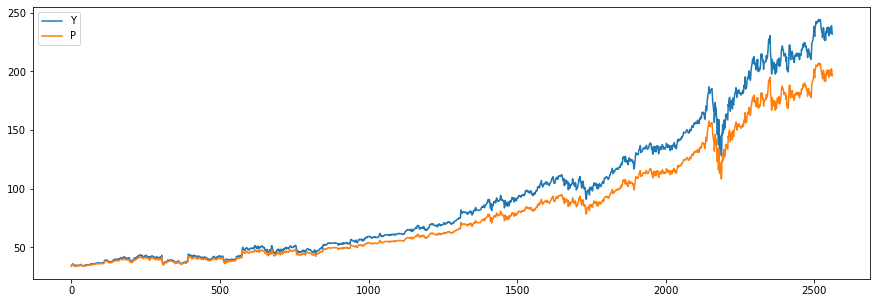

In [350]:
predictions=model.predict(vtx)
print("outputShape",predictions.shape)
vEvals=model.evaluate(vtx,vty,verbose=0)
%store vEvals >>a.txt
# print("Val Loss:",vEvals[0],"\tVal MAE:",vEvals[1])
plotCompare(vtx[:,-1],predictions[:,-1],["Y","P"])



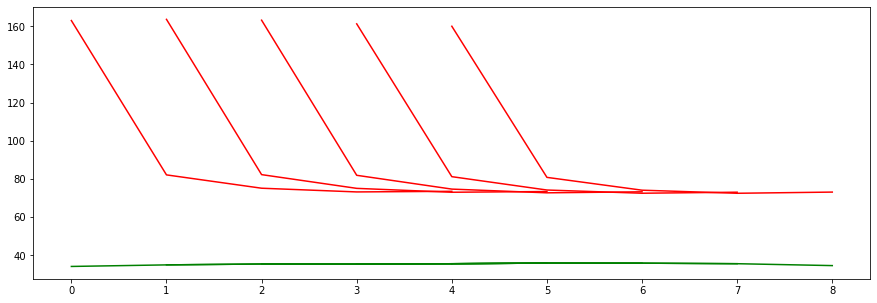

KeyboardInterrupt: 

In [404]:
plotVisual(vy,predictions,5)

In [412]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
	inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
	padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
	attention = MultiHeadAttention(d_model, num_heads, name="attention")(inputs, inputs, inputs, padding_mask)
	attention = tf.keras.layers.Dropout(rate=dropout)(attention)
	attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
	outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
	outputs = tf.keras.layers.Dense(units=d_model)(outputs)
	outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
	outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
	return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
def encoder(vocab_size,num_layers,units,d_model,num_heads,dropout,name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    for i in range(num_layers):
        outputs = encoder_layer(units=units,d_model=d_model,num_heads=num_heads,dropout=dropout,name="encoder_layer_{}".format(i),)([outputs, padding_mask])
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.supports_masking = True
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class ScalerMult(Layer):
    def __init__(self, d_model):
        super(ScalerMult, self).__init__()
        self.mult = tf.math.sqrt(tf.cast(d_model, tf.float32))
        self.supports_masking = True
    def call(self, inputs):
        return inputs * self.mult   


In [413]:
def Encoder_Model(M,embedding_dim,hidden):
    AT=MultiHeadAttention(num_heads=embedding_dim,key_dim=5)(M,M,M)
    AD1=Add()([AT,M])
    NORM1=LayerNormalization()(AD1)
    FF=Dense(hidden,'relu')(NORM1)
    FF=Dense(embedding_dim,'relu')(FF)
    AD2=Add()([FF,NORM1])
    norm=LayerNormalization()(AD2)
    return norm
#     return tf.keras.models.Model(inputs=AT,outputs=norm, name="encoder") 


In [414]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model( sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=140,encoders=1):
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)
    E=Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=False)(V)
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(len(vec_layer.get_vocabulary()),embedding_dim)(E)
    P=Masking()(P)
    out=Dense(1,'linear')(P)
#     for N in range (encoders):
#         out= out(Encoder_Model(P,embedding_dim,hidden))
#     out=Flatten()(out)
#     out=Dense(1,'linear')(out)
#     out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M
model=Transformer_Encoder_Model(encoders=2)
# tf.keras.utils.plot_model(Transformer_Encoder_Model)
# model.summary()
# LSTM_model()
# H=model.fit(trainX.values, trainY[cat2].values,epochs=100,batch_size=500,validation_split=0.1,callbacks=callbacks)